In [8]:
!pip install pandas==0.22

     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     --- ------------------------------------ 1.0/11.3 MB 16.7 MB/s eta 0:00:01
     ------- -------------------------------- 2.1/11.3 MB 7.3 MB/s eta 0:00:02
     ----------------------- ---------------- 6.6/11.3 MB 10.3 MB/s eta 0:00:01
     ------------------------------------ -- 10.5/11.3 MB 13.6 MB/s eta 0:00:01
     --------------------------------------- 11.3/11.3 MB 12.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [71 lines of output]
      Ignoring numpy: markers 'python_version == "3.5"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
        Using cached wheel-0.44.0-py3-none-any.whl.metadata (2.3 kB)
        Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
        Using cached Cython-3.0.11-cp38-cp38-win_amd64.whl.metadata (3.2 kB)
           ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
           --------------------------------- ------ 4.2/5.0 MB 22.9 MB/s eta 0:00:01
           ---------------------------------------- 5.0/5.0 MB 20.3 MB/s eta 0:00:00
        Preparing metadata (setup.py): started
        Preparing metadata (setup.py): finished with status 'done'
      Using cached wheel-0.44.0-py3-none-any.whl (67 kB)
      Using cached setuptools-75

In [2]:
# !pip install mediapipe opencv-python scikit-learn==0.24.1

In [1]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
import csv
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
import sklearn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle 
import time
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [3]:
import numpy as np
print(np.__version__)

1.24.4


In [4]:
print(mp.__version__)

0.10.10


In [5]:
import sklearn
print(sklearn.__version__)

0.24.1


In [6]:
with open("C:/Users/USER/Downloads/body_language.pkl", 'rb') as f:
    model = pickle.load(f)

In [6]:
model.predict[0]

TypeError: 'function' object is not subscriptable

In [7]:
def calculate_angle(a,b):
    a = np.array(a)
    b = np.array(b)
    
    radians = np.arctan2(b[1]-a[1], b[0]-a[0])
    angle = np.abs(radians*180.0/np.pi)

    return angle 

In [9]:
# 선택한 이미지를 불러옵니다
overlay_image = cv2.imread('./background.png', cv2.IMREAD_UNCHANGED)  # 이미지 파일 경로 지정

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

cap = cv2.VideoCapture("C:/Users/USER/Downloads/recorded_video_2024-11-04T02_55_59.985Z.webm")

def get_eye_region(landmarks, indexes, scale_x, scale_y):
    # 랜드마크 좌표를 사용하여 눈 영역 추출
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    # 홍채 중심 좌표 계산
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    val_iris_center = np.mean(iris_points, axis=0)
    return iris_center, val_iris_center

# Curl counter variables
warning = False
pose_bad_count = 0
pose_good_count = 0
eye_bad_count = 0
eye_good_count = 0

# stretch_count = 0
# stand_count = 0
start = time.gmtime(time.time())  # 시작 시간 저장

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
avg_pose_bad_count_per_second = 0
avg_pose_good_count_per_second = 0
total_eye_bad_count = 0
total_eye_good_count = 0
avg_eye_bad_count_per_second = 0
avg_eye_good_count_per_second = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
# # Initiate holistic model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

left_iris_list = []
right_iris_list = []
uclid_distance = []
angles = []
# left_uclid_distance = []
# right_uclid_distance = []

# print(cap.read())

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # 거울모드
    frame = cv2.flip(frame, 1)

    # 원본 크기 저장
    original_height, original_width = frame.shape[:2]

    # 프레임 리사이즈
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

    # 리사이즈된 이미지의 크기
    resized_height, resized_width = resize_frame.shape[:2]

    # 리사이즈 비율 계산
    scale_x = resized_width / original_width
    scale_y = resized_height / original_height

    # Recolor Feed
    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False        
    
    # Make Detections
    results = holistic.process(image)
    
    # Recolor image back to BGR for rendering
    image.flags.writeable = True   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # 1. Draw face landmarks
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          )
    
    # 2. Right hand
    # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          )

    # 3. Left Hand
    # mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
    #                          mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
    #                          )

    # 4. Pose Detections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    
    # 얼굴 랜드마크 그리기 및 눈동자 추출
    face_result = face_mesh.process(image)

    try:
        landmarks = results.pose_landmarks.landmark
        # Get coordinates
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        
        # # Calculate angle
        angle = calculate_angle(left_shoulder, right_shoulder)
        angles.append(angle)
        # Curl counter logic
        temp_pose = ''
        if angle < 176:
            pose_bad_count += 1
            total_pose_bad_count += 1
            temp_pose = 'BAD' 
        elif angle >= 176:
            pose_good_count += 1
            total_pose_good_count += 1
            temp_pose = 'GOOD'
        pose_frame_counter += 1

        if pose_frame_counter >= 30:
            avg_pose_bad_count_per_second = round(total_pose_bad_count / 30, 8)
            avg_pose_good_count_per_second = round(total_pose_good_count / 30, 8)

            # 변수 리셋
            pose_frame_counter = 0
            total_pose_bad_count = 0
            total_pose_good_count = 0
            


        # Extract Pose landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        
        # Extract Face landmarks
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        # Concate rows
        row = pose_row+face_row
        
        # Make Detections
        X = np.array([row])

        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
        # Get status box
        cv2.putText(image, f'angle : {angle}', (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'good_pose_count : {avg_pose_good_count_per_second}', (10,65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'bad_pose_count : {avg_pose_bad_count_per_second}', (10,105), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'Pose is good?: {temp_pose}', (10, 235), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
        
        #Time
        now = time.gmtime(time.time())
        
        cv2.putText(image, 'Time', 
                    (440,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        seconds = 0
        minute = 0
        if now.tm_sec < start.tm_sec:
            seconds = 60 - start.tm_sec + now.tm_sec
        else:
            seconds = abs(now.tm_sec - start.tm_sec)

        cv2.putText(image, str(minute) +' : '+ str(seconds),
                    (500,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        
        # 얼굴 랜드마크가 있으면 처리
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                
                # 왼쪽 눈과 오른쪽 눈 영역 추출 (크기 비율 적용)
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)

                # 눈 영역에 다각형 그리기
                cv2.polylines(image, [left_eye], isClosed=True, color=(0, 255, 0), thickness=1)
                cv2.polylines(image, [right_eye], isClosed=True, color=(0, 255, 0), thickness=1)

                # 왼쪽 및 오른쪽 홍채 중심 추출
                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)
                left_iris_list.append(val_left_iris_center)
                right_iris_list.append(val_right_iris_center)
                # left_uclid_distance.append(np.linalg.norm(left_eye - val_left_iris_center))
                # right_uclid_distance.append(np.linalg.norm(right_eye - val_right_iris_center))

                temp = (np.linalg.norm(left_eye - val_left_iris_center) + np.linalg.norm(right_eye - val_right_iris_center)) / 2

                uclid_distance.append(temp)
                # 홍채 중심에 원 그리기
                cv2.circle(image, tuple(left_iris_center), 3, (255, 0, 0), -1)
                cv2.circle(image, tuple(right_iris_center), 3, (255, 0, 0), -1)

                # 왼쪽 눈동자 중심 계산
                left_eye_center = np.mean(left_eye, axis=0)
                right_eye_center = np.mean(right_eye, axis=0)

                # 눈동자 중심에 원 그리기
                # cv2.circle(image, tuple(left_eye_center), 3, (0, 255, 0), -1)
                # cv2.circle(image, tuple(right_eye_center), 3, (0, 255, 0), -1)

                left_eye_direction = ''
                right_eye_direction = ''

                if -3 < left_eye_center[0] - val_left_iris_center[0] <= 2 and 0.3 <= left_eye_center[1] - val_left_iris_center[1] <= 1.7:
                    left_eye_direction = 'center'
                elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 3 and  left_eye_center[1] - val_left_iris_center[1] > 1.7:
                    left_eye_direction = 'top'
                elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 3 and  left_eye_center[1] - val_left_iris_center[1] < 0.3:
                    left_eye_direction = 'bottom'
                elif left_eye_center[0] - val_left_iris_center[0] > 2:
                    left_eye_direction = 'left'
                elif left_eye_center[0] - val_left_iris_center[0] < -3:
                    left_eye_direction = 'right'

                if  -2.5 <= right_eye_center[0] - val_right_iris_center[0] <= 2.5 and 0.3 <= right_eye_center[1] - val_right_iris_center[1] <= 1.7:
                    right_eye_direction = 'center'
                elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 3 and right_eye_center[1] - val_right_iris_center[1] > 1.7:
                    right_eye_direction = 'top'
                elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 3 and right_eye_center[1] - val_right_iris_center[1] < 0.3:
                    right_eye_direction = 'bottom'
                elif right_eye_center[0] - val_right_iris_center[0] > 2.5:
                    right_eye_direction = 'left'
                elif right_eye_center[0] - val_right_iris_center[0] < -2.5:
                    right_eye_direction = 'right'

                eye_temp = ''
                
                if left_eye_direction == right_eye_direction and left_eye_direction != 'center':
                    eye_bad_count += 1
                    total_eye_bad_count += 1
                    # good_count = 0
                    eye_temp='BAD'
                else:
                    eye_good_count += 1
                    total_eye_good_count += 1
                    eye_temp='GOOD'

                eye_frame_counter += 1

                if eye_frame_counter >= 30:
                    avg_eye_bad_count_per_second = round(total_eye_bad_count / 30, 8)
                    avg_eye_good_count_per_second = round(total_eye_good_count / 30, 8)

                    # 변수 리셋
                    eye_frame_counter = 0
                    total_eye_bad_count = 0
                    total_eye_good_count = 0
                

                # 홍채 좌표 출력
                cv2.putText(image, f'L Iris: {val_left_iris_center}', (440, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'R Iris: {val_right_iris_center}', (440, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 눈동자 중심 좌표 출력
                cv2.putText(image, f'L eye: {left_eye_center}', (440, 105), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'R eye: {right_eye_center}', (440, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 눈 방향
                cv2.putText(image, f'good eye count: {avg_eye_good_count_per_second}', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'bad eye count: {avg_eye_bad_count_per_second}', (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 시선 벗어났는지
                cv2.putText(image, f'Eye is good?: {eye_temp}', (620, 235), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
                # cv2.putText(image, f'L eye direction: {avg_eye_bad_count_per_second}', (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # cv2.putText(image, f'R eye direction: {avg_eye_good_count_per_second}', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)

    except Exception as e:
        print(e)

    # 원하는 이미지 크기와 위치 설정
    overlay_width = 600  # 이미지의 가로 크기
    overlay_height = 600  # 이미지의 세로 크기
    overlay_position = (180, 120)  # 이미지가 배치될 왼쪽 위 좌표 (x, y)

    # 선택한 이미지를 리사이즈
    overlay_resized = cv2.resize(overlay_image, (overlay_width, overlay_height))

    # ROI(Region of Interest)를 설정하여 이미지를 해당 위치에 삽입
    x, y = overlay_position
    roi = image[y:y+overlay_height, x:x+overlay_width]
    
    # 알파 채널 분리
    if overlay_resized.shape[2] == 4:  # 이미지가 알파 채널을 가지고 있는지 확인
        overlay_img = overlay_resized[:, :, :3]  # RGB 채널
        mask = overlay_resized[:, :, 3]  # 알파 채널

        # 알파 채널을 [0, 1] 범위로 정규화
        mask = mask / 255.0

        # 불투명도 조정 (원하는 값으로 alpha 설정)
        alpha = 0.4  # 불투명도: 1.0은 완전 불투명, 0.0은 완전 투명

        # 배경에 원래 프레임의 해당 부분 복사
        background = (1.0 - mask * alpha)[:, :, np.newaxis] * roi
        # 전경에 overlay 이미지 복사
        foreground = (mask * alpha)[:, :, np.newaxis] * overlay_img

        # 배경과 전경을 더해 합성
        blended = background + foreground

        # 합성된 이미지를 원본 프레임에 적용
        image[y:y+overlay_height, x:x+overlay_width] = blended

    # 결과 이미지 출력
    cv2.imshow('Camera Feed with Transparent Image Overlay', image)

    # q를 눌러서 종료
    if cv2.waitKey(10) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
import cv2
import numpy as np
import mediapipe as mp
import time

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh
mp_holistic = mp.solutions.holistic

# 이미지 오버레이 설정
overlay_image = cv2.imread('./background.png', cv2.IMREAD_UNCHANGED)  # 이미지 파일 경로 지정

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]
LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

# 비디오 파일 경로 지정
cap = cv2.VideoCapture(0)

def get_eye_region(landmarks, indexes, scale_x, scale_y):
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    val_iris_center = np.mean(iris_points, axis=0)
    return iris_center, val_iris_center

# 카운터 변수 초기화
warning = False
pose_bad_count = 0
pose_good_count = 0
eye_bad_count = 0
eye_good_count = 0

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
total_eye_bad_count = 0
total_eye_good_count = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # 거울모드
    original_height, original_width = frame.shape[:2]
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    resized_height, resized_width = resize_frame.shape[:2]
    scale_x = resized_width / original_width
    scale_y = resized_height / original_height
    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # 포즈 랜드마크
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

    # 얼굴 랜드마크
    face_result = face_mesh.process(image)

    try:
        landmarks = results.pose_landmarks.landmark
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

        # 포즈 검사 및 카운팅 로직
        # (예제 코드에서 각도 계산은 필요시 추가)
        # 눈과 홍채 검사
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)

                cv2.polylines(image, [left_eye], isClosed=True, color=(0, 255, 0), thickness=1)
                cv2.polylines(image, [right_eye], isClosed=True, color=(0, 255, 0), thickness=1)

                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)

                cv2.circle(image, tuple(left_iris_center), 3, (255, 0, 0), -1)
                cv2.circle(image, tuple(right_iris_center), 3, (255, 0, 0), -1)

                # 눈 방향 검사 추가 가능

    except Exception as e:
        print(e)

    # 오버레이 설정
    overlay_width, overlay_height = 600, 600
    overlay_position = (180, 120)
    overlay_resized = cv2.resize(overlay_image, (overlay_width, overlay_height))
    x, y = overlay_position
    roi = image[y:y+overlay_height, x:x+overlay_width]
    
    # 투명도 설정
    if overlay_resized.shape[2] == 4:
        overlay_img = overlay_resized[:, :, :3]
        mask = overlay_resized[:, :, 3] / 255.0
        alpha = 0.4
        background = (1.0 - mask * alpha)[:, :, np.newaxis] * roi
        foreground = (mask * alpha)[:, :, np.newaxis] * overlay_img
        blended = background + foreground
        image[y:y+overlay_height, x:x+overlay_width] = blended

    # cv2.imshow('Camera Feed with Transparent Image Overlay', image)
    if cv2.waitKey(10) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute

KeyboardInterrupt: 

In [ ]:
import mediapipe as mp  # Import mediapipe
import cv2  # Import opencv
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import pickle
import os

# 시각화를 위한 함수
def calculate_angle(a, b):
    a = np.array(a)
    b = np.array(b)
    
    radians = np.arctan2(b[1] - a[1], b[0] - a[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh

# 모델 로드
with open("C:/Users/USER/Downloads/body_language.pkl", 'rb') as f:
    model = pickle.load(f)

# 비디오 파일 경로
cap = cv2.VideoCapture("C:/Users/USER/Downloads/recorded_video_2024-11-04T02_55_59.985Z.webm")

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]
LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

# Eye and Pose related variables
uclid_distance = []

# Eye Region Extract Function
def get_eye_region(landmarks, indexes, scale_x, scale_y):
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

# Iris Center Calculation Function
def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    return iris_center, np.mean(iris_points, axis=0)

# 시간 및 카운팅 변수
start = time.gmtime(time.time())

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
avg_pose_bad_count_per_second = 0
avg_pose_good_count_per_second = 0
total_eye_bad_count = 0
total_eye_good_count = 0
avg_eye_bad_count_per_second = 0
avg_eye_good_count_per_second = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Iris List for Distance Calculation
left_iris_list = []
right_iris_list = []

# 사용자 이름을 바탕으로 저장할 파일명을 동적으로 설정
user_name = "hufaga"  # 사용자 이름 

# 유형 별 id 추가
# 면접 별 id 추가 

# model 별 이름 추가
model = 'eye'
output_dir = "C:/Users/USER/Desktop/API/API/ai/eye_pose_detection/output_plot"  # 원하는 경로 

# 사용자 이름을 포함한 파일 경로 설정
eye_output_filename = f"{user_name}_{model}_plot.png"
eye_output_path = os.path.join(output_dir, model, eye_output_filename)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Flip the frame (mirror mode)
    frame = cv2.flip(frame, 1)

    original_height, original_width = frame.shape[:2]

    # Resize frame for better detection
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    resized_height, resized_width = resize_frame.shape[:2]

    scale_x = resized_width / original_width
    scale_y = resized_height / original_height

    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Handle pose and face landmarks
    try:
        landmarks = results.pose_landmarks.landmark
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        
        angle = calculate_angle(left_shoulder, right_shoulder)
        
        pose_frame_counter += 1

        # Extract Pose and Face Landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        row = pose_row + face_row
        X = np.array([row])

        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
        
        # Face Mesh Handling
        face_result = face_mesh.process(image)
        
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)
                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)
                
                left_iris_list.append(val_left_iris_center)
                right_iris_list.append(val_right_iris_center)

                temp = (np.linalg.norm(left_eye - val_left_iris_center) + np.linalg.norm(right_eye - val_right_iris_center)) / 2
                uclid_distance.append(temp)

    except Exception as e:
        print(e)

# 비디오 종료 후, 히스토그램 그래프 생성 및 저장
# uclid_distance 값으로 히스토그램 생성
data = np.array(uclid_distance)
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 데이터 계산
counts, bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))
ax = plt.gca()

# 격자 다루기
ax.grid(zorder=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False, axis='x')

# 각 막대를 둥근 모서리로 그리기
for i in range(len(bins) - 1):
    if counts[i] != 0:
        x = bins[i]
        width = bins[i + 1] - bins[i]
        height = counts[i]
        rect = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc", zorder=5)
        ax.add_patch(rect)

# 축 범위 설정
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0, max(counts) + 2)

# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Rounded Bars') ## 면접 별 단계 별 이름 설정

# eye 그래프 저장
plt.savefig(eye_output_path, bbox_inches='tight')  # 사용자 이름을 바탕으로 경로에 그래프를 저장

# # 히스토그램 출력
# plt.show()

# pose 그래프 

cap.release()
cv2.destroyAllWindows()


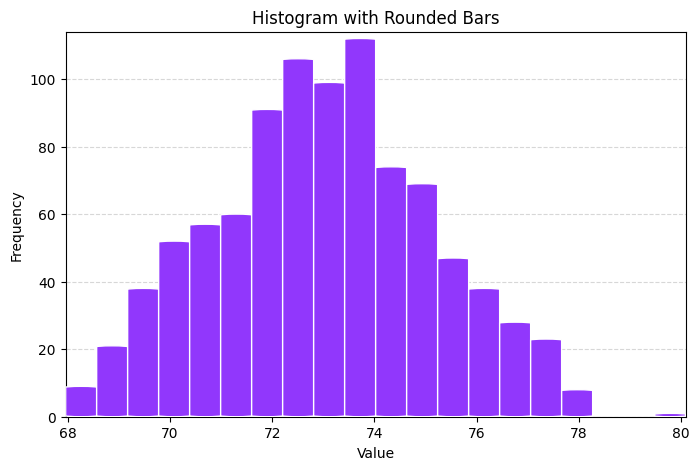

In [13]:
import mediapipe as mp  # Import mediapipe
import cv2  # Import opencv
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import pickle
import os

# 시각화를 위한 함수
def calculate_angle(a, b):
    a = np.array(a)
    b = np.array(b)
    
    radians = np.arctan2(b[1] - a[1], b[0] - a[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh

# 모델 로드
with open("C:/Users/USER/Downloads/body_language.pkl", 'rb') as f:
    model = pickle.load(f)

# 비디오 파일 경로
cap = cv2.VideoCapture("C:/Users/USER/Downloads/recorded_video_2024-11-04T02_55_59.985Z.webm")

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]
LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

# Eye and Pose related variables
uclid_distance = []

# Eye Region Extract Function
def get_eye_region(landmarks, indexes, scale_x, scale_y):
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

# Iris Center Calculation Function
def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    return iris_center, np.mean(iris_points, axis=0)

# 시간 및 카운팅 변수
start = time.gmtime(time.time())

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
avg_pose_bad_count_per_second = 0
avg_pose_good_count_per_second = 0
total_eye_bad_count = 0
total_eye_good_count = 0
avg_eye_bad_count_per_second = 0
avg_eye_good_count_per_second = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Iris List for Distance Calculation
left_iris_list = []
right_iris_list = []

# 사용자 이름을 바탕으로 저장할 파일명을 동적으로 설정
user_name = "username"  # 사용자 이름 (예시: 'john_doe')
output_dir = "C:/Users/USER/Desktop/API/API/ai/eye_pose_detection/output_plot/eye"  # 원하는 경로 (예시: '/home/user/output')

# 사용자 이름을 포함한 파일 경로 설정
output_filename = f"{user_name}_plot.png"
output_path = os.path.join(output_dir, output_filename)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Flip the frame (mirror mode)
    frame = cv2.flip(frame, 1)

    original_height, original_width = frame.shape[:2]

    # Resize frame for better detection
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    resized_height, resized_width = resize_frame.shape[:2]

    scale_x = resized_width / original_width
    scale_y = resized_height / original_height

    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Handle pose and face landmarks
    try:
        landmarks = results.pose_landmarks.landmark
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        
        angle = calculate_angle(left_shoulder, right_shoulder)

        pose_frame_counter += 1

        # Extract Pose and Face Landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        row = pose_row + face_row
        X = np.array([row])

        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
        
        # Face Mesh Handling
        face_result = face_mesh.process(image)
        
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)
                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)
                
                left_iris_list.append(val_left_iris_center)
                right_iris_list.append(val_right_iris_center)

                temp = (np.linalg.norm(left_eye - val_left_iris_center) + np.linalg.norm(right_eye - val_right_iris_center)) / 2
                uclid_distance.append(temp)

    except Exception as e:
        print(e)

# 비디오 종료 후, 히스토그램 그래프 생성 및 저장
# uclid_distance 값으로 히스토그램 생성
data = np.array(uclid_distance)
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 데이터 계산
eye_counts, eye_bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.grid(zorder=0)

# 각 막대를 둥근 모서리로 그리기
for i in range(len(eye_bins) - 1):
    if eye_counts[i] != 0:
        x = eye_bins[i]
        width = eye_bins[i + 1] - eye_bins[i]
        height = eye_counts[i]
        rect = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc",zorder=5)
        ax.add_patch(rect)

# 축 범위 설정
ax.set_xlim(eye_bins[0], eye_bins[-1])
ax.set_ylim(0, max(eye_counts) + 2)

# 격자 다루기
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False, axis='x')

# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Rounded Bars')

# 그래프 저장
plt.savefig(output_path, bbox_inches='tight')  # 사용자 이름을 바탕으로 경로에 그래프를 저장

# 히스토그램 출력
plt.show()

cap.release()
cv2.destroyAllWindows()


FancyBboxPatch((67.9584, 0), width=0.606713, height=9)
FancyBboxPatch((68.5651, 0), width=0.606713, height=21)
FancyBboxPatch((69.1719, 0), width=0.606713, height=38)
FancyBboxPatch((69.7786, 0), width=0.606713, height=52)
FancyBboxPatch((70.3853, 0), width=0.606713, height=57)
FancyBboxPatch((70.992, 0), width=0.606713, height=60)
FancyBboxPatch((71.5987, 0), width=0.606713, height=91)
FancyBboxPatch((72.2054, 0), width=0.606713, height=106)
FancyBboxPatch((72.8121, 0), width=0.606713, height=99)
FancyBboxPatch((73.4189, 0), width=0.606713, height=112)
FancyBboxPatch((74.0256, 0), width=0.606713, height=74)
FancyBboxPatch((74.6323, 0), width=0.606713, height=69)
FancyBboxPatch((75.239, 0), width=0.606713, height=47)
FancyBboxPatch((75.8457, 0), width=0.606713, height=38)
FancyBboxPatch((76.4524, 0), width=0.606713, height=28)
FancyBboxPatch((77.0591, 0), width=0.606713, height=23)
FancyBboxPatch((77.6658, 0), width=0.606713, height=8)
FancyBboxPatch((79.486, 0), width=0.606713, height

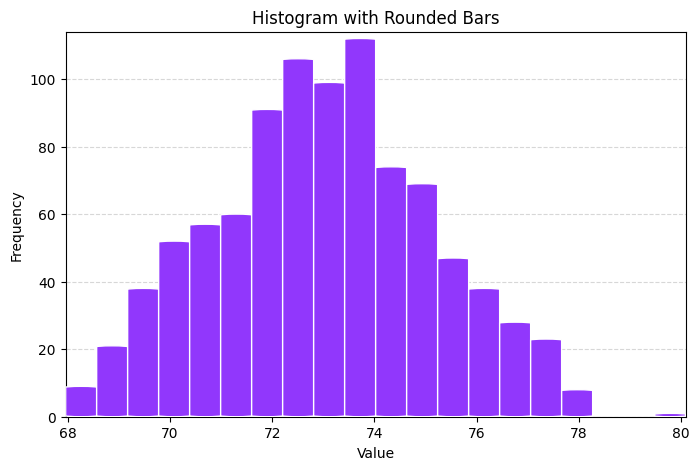

In [37]:
data = np.array(uclid_distance)
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 데이터 계산
eye_counts, eye_bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.grid(zorder=0)

# 각 막대를 둥근 모서리로 그리기
for i in range(len(eye_bins) - 1):
    if eye_counts[i] != 0:
        x = eye_bins[i]
        width = eye_bins[i + 1] - eye_bins[i]
        height = eye_counts[i]
        rect_1 = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc",zorder=5)
        print(rect_1)
        ax.add_patch(rect_1)

# 축 범위 설정
ax.set_xlim(eye_bins[0], eye_bins[-1])
ax.set_ylim(0, max(eye_counts) + 2)

# 격자 다루기
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False, axis='x')

# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Rounded Bars')

# 그래프 저장
plt.savefig(output_path, bbox_inches='tight')  # 사용자 이름을 바탕으로 경로에 그래프를 저장

# 히스토그램 출력
plt.show()

cap.release()
cv2.destroyAllWindows()

[29 71 42 43 32 23 53 38 44 66 94 66 95 85 55 32  8 22 30  5]
FancyBboxPatch((176.698, 0), width=0.142168, height=29)
FancyBboxPatch((176.84, 0), width=0.142168, height=71)
FancyBboxPatch((176.982, 0), width=0.142168, height=42)
FancyBboxPatch((177.125, 0), width=0.142168, height=43)
FancyBboxPatch((177.267, 0), width=0.142168, height=32)
FancyBboxPatch((177.409, 0), width=0.142168, height=23)
FancyBboxPatch((177.551, 0), width=0.142168, height=53)
FancyBboxPatch((177.693, 0), width=0.142168, height=38)
FancyBboxPatch((177.835, 0), width=0.142168, height=44)
FancyBboxPatch((177.978, 0), width=0.142168, height=66)
FancyBboxPatch((178.12, 0), width=0.142168, height=94)
FancyBboxPatch((178.262, 0), width=0.142168, height=66)
FancyBboxPatch((178.404, 0), width=0.142168, height=95)
FancyBboxPatch((178.546, 0), width=0.142168, height=85)
FancyBboxPatch((178.688, 0), width=0.142168, height=55)
FancyBboxPatch((178.831, 0), width=0.142168, height=32)
FancyBboxPatch((178.973, 0), width=0.142168,

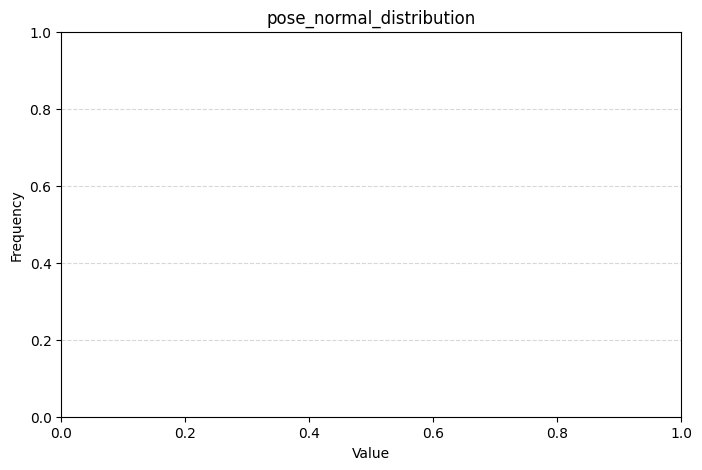

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch


## pose plot
pose_data = np.array(angles)

pose_counts, pose_bins = np.histogram(pose_data, bins=20)

plt.figure(figsize=(8, 5))
ax = plt.gca()
print(pose_counts)
for i in range(len(pose_bins) - 1):
    if pose_counts[i] != 0:
        x = pose_bins[i]

        width = pose_bins[i + 1] - pose_bins[i]
        
        height = pose_counts[i]

        rect_pose = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc", zorder=5)
        print(rect_pose)
        ax.add_patch(rect_pose)

# 격자 다루기
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False, axis='x')

# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('pose_normal_distribution')


# print(first_angle)
plt.savefig('C:/Users/USER/Desktop/API/API/ai/eye_pose_detection/output_plot/pose/posepy_test', bbox_inches='tight')

plt.show()
# plt.close()

In [4]:
print(f'l_iris : {left_iris_list}')
print()
print(f'r_iris : {right_iris_list}')
print()
print(f'l_uclid : {uclid_distance}')
print()
print(f'r_uclid : {uclid_distance}')

l_iris : []

r_iris : []

l_uclid : []

r_uclid : []


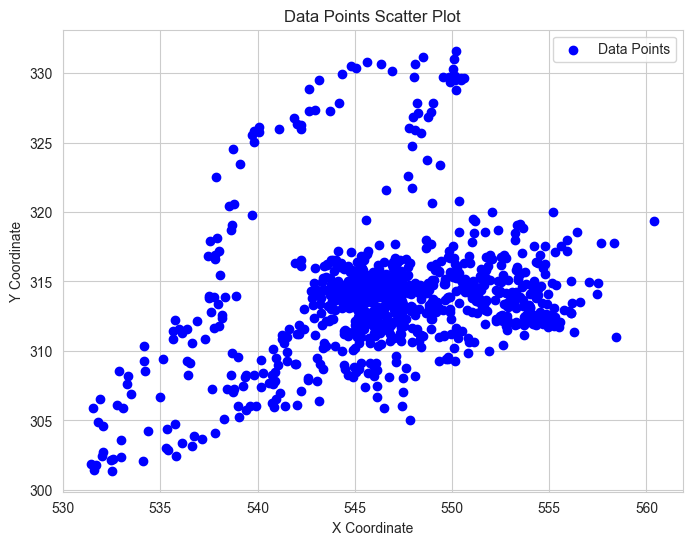

In [192]:
left_data = np.array(left_iris_list)
right_data = np.array(right_iris_list)
# 데이터에서 x와 y 좌표 분리
x = right_data[:, 0]
y = right_data[:, 1]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='b', label='Data Points')  # scatter plot으로 점만 표시

# 그래프 제목과 라벨 추가
plt.title('Data Points Scatter Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\desired\\output\\path\\username_plot.png'

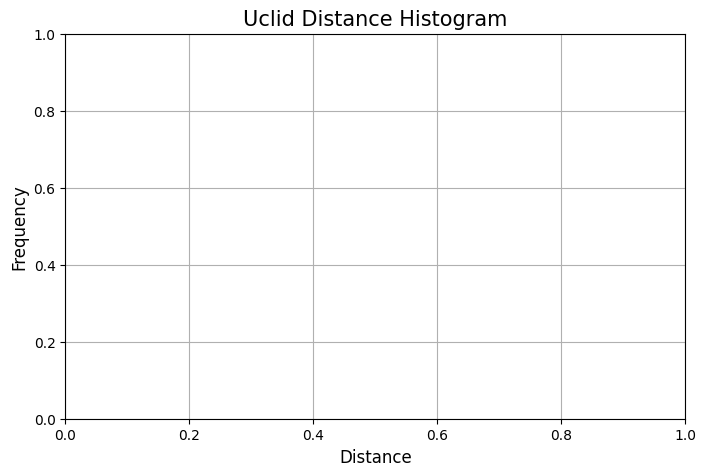

In [19]:
import mediapipe as mp  # Import mediapipe
import cv2  # Import opencv
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import pickle
import os

# 시각화를 위한 함수
def calculate_angle(a, b):
    a = np.array(a)
    b = np.array(b)
    
    radians = np.arctan2(b[1] - a[1], b[0] - a[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh

# 모델 로드
with open("C:/Users/USER/Downloads/body_language.pkl", 'rb') as f:
    model = pickle.load(f)

# 비디오 파일 경로
cap = cv2.VideoCapture("C:/Users/USER/Downloads/recorded_video_2024-11-04T02_55_59.985Z.webm")

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]
LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

# Eye and Pose related variables
uclid_distance = []

# Eye Region Extract Function
def get_eye_region(landmarks, indexes, scale_x, scale_y):
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

# Iris Center Calculation Function
def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    return iris_center, np.mean(iris_points, axis=0)

# 시간 및 카운팅 변수
start = time.gmtime(time.time())

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
avg_pose_bad_count_per_second = 0
avg_pose_good_count_per_second = 0
total_eye_bad_count = 0
total_eye_good_count = 0
avg_eye_bad_count_per_second = 0
avg_eye_good_count_per_second = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Iris List for Distance Calculation
left_iris_list = []
right_iris_list = []

# 사용자 이름을 바탕으로 저장할 파일명을 동적으로 설정
user_name = "username"  # 사용자 이름 (예시: 'john_doe')
output_dir = "/desired/output/path"  # 원하는 경로 (예시: '/home/user/output')

# 사용자 이름을 포함한 파일 경로 설정
output_filename = f"{user_name}_plot.png"
output_path = os.path.join(output_dir, output_filename)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Flip the frame (mirror mode)
    frame = cv2.flip(frame, 1)

    original_height, original_width = frame.shape[:2]

    # Resize frame for better detection
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    resized_height, resized_width = resize_frame.shape[:2]

    scale_x = resized_width / original_width
    scale_y = resized_height / original_height

    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Handle pose and face landmarks
    try:
        landmarks = results.pose_landmarks.landmark
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        
        angle = calculate_angle(left_shoulder, right_shoulder)

        pose_frame_counter += 1

        # Extract Pose and Face Landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        row = pose_row + face_row
        X = np.array([row])

        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
        
        # Face Mesh Handling
        face_result = face_mesh.process(image)
        
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)
                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)
                
                left_iris_list.append(val_left_iris_center)
                right_iris_list.append(val_right_iris_center)

                temp = (np.linalg.norm(left_eye - val_left_iris_center) + np.linalg.norm(right_eye - val_right_iris_center)) / 2
                uclid_distance.append(temp)

    except Exception as e:
        print(e)

# 비디오 종료 후, 히스토그램 그래프 생성 및 저장
# uclid_distance 값으로 히스토그램 생성
data = np.array(uclid_distance)
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 데이터 계산
counts, bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))
ax = plt.gca()

# 각 막대를 둥근 모서리로 그리기
for i in range(len(bins) - 1):
    if counts[i] != 0:
        x = bins[i]
        width = bins[i + 1] - bins[i]
        height = counts[i]
        rect = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc", zorder=5)  # 그래프의 zorder를 높여서 격자 위로 그려짐
        ax.add_patch(rect)

# 축과 격자 설정
ax.grid(True, zorder=0)  # 격자의 zorder를 낮게 설정하여 그래프 아래로
ax.set_title("Uclid Distance Histogram", fontsize=15)
ax.set_xlabel("Distance", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

# 그래프 저장 (파일명에 사용자 이름 포함)
plt.savefig(output_path, bbox_inches='tight')

# 히스토그램 출력
plt.show()

cap.release()
cv2.destroyAllWindows()


[71.25975632 72.62412656 72.10923957 72.16107743 72.5934837  72.52889121
 73.29595664 73.07062721 73.93527098 72.75417042 73.70192419 72.76240777
 71.45872023 70.88448049 71.12800285 72.60011683 73.11284094 72.1809788
 73.60641987 71.53636077 72.00137193 70.06127801 70.43793437 71.97603378
 70.51171344 72.52162244 71.98703651 72.01757361 72.57834776 72.94339145
 72.6608485  72.72963993 73.14908746 73.68461409 72.54692823 72.27067112
 71.77888463 72.76849087 72.49630132 73.93754447 72.98288738 73.67213646
 74.41070425 74.27512294 73.40390429 73.56197215 73.09344896 72.53963396
 73.3916892  73.72609132 74.1460763  74.07856924 75.15116001 74.34038118
 72.73683693 74.44006306 73.83559141 73.17147497 73.80667751 74.08432204
 74.5236319  73.49197779 73.96517016 73.02723049 73.70966082 74.89028881
 74.80514818 73.46348714 72.53571323 72.7242375  74.60718436 74.8931073
 73.22068327 75.18199966 75.266771   76.16579119 75.30136677 72.98383579
 74.84044507 74.06698671 73.59610063 72.96722539 75.0

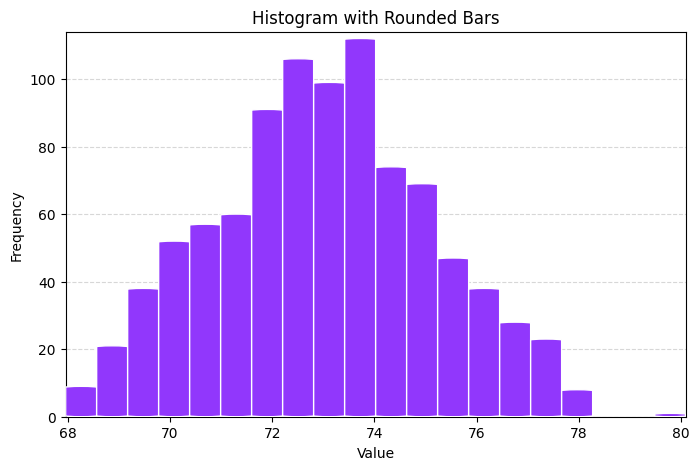

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch

# 정규분포 데이터 생성
data = np.array(uclid_distance)
mean = np.mean(data)
std_dev = np.std(data)

print(data)
# 히스토그램 데이터 계산
counts, bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))

# 격자 다루기
ax.grid(True, zorder=0)
plt.grid(True ,axis='y', linestyle='--', alpha=0.5)
# plt.grid(False, axis='x')

ax = plt.gca()

# 각 막대를 둥근 모서리로 그리기
for i in range(len(bins) - 1):
    if counts[i] != 0:
        x = bins[i]

        width = bins[i + 1] - bins[i]
        
        height = counts[i]

        rect = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.3",
                            edgecolor="white", facecolor="#9137fc", zorder=5)
        ax.add_patch(rect)

# # 정규분포 곡선 계산 
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mean, std_dev)

# plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

# 축 범위 설정
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0, max(counts) + 2)



# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Rounded Bars')
plt.show()


933
[66.38623985 66.97059638 67.5549529  68.13930943 68.72366596 69.30802248
 69.89237901 70.47673554 71.06109206 71.64544859 72.22980512 72.81416164
 73.39851817 73.9828747  74.56723122 75.15158775 75.73594428 76.3203008
 76.90465733 77.48901386 78.07337038 78.65772691 79.24208344 79.82643996
 80.41079649 80.99515302 81.57950954 82.16386607 82.7482226  83.33257912
 83.91693565]


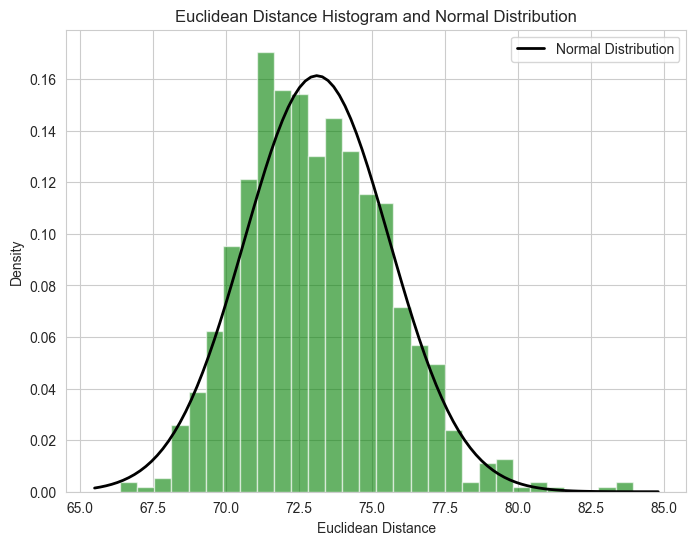

In [193]:
# 데이터를 numpy 배열로 변환
data = np.array(uclid_distance)

# 평균과 표준편차 계산
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 그리기
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
print(bins)

# 정규분포 곡선 계산
xmin, xmax = plt.xlim()  # 히스토그램의 범위 가져오기
x = np.linspace(xmin, xmax, 100)  # xmin에서 xmax까지 100개의 점 생성
p = norm.pdf(x, mean, std_dev)  # 평균과 표준편차를 기반으로 정규분포 계산

# 정규분포 곡선 그리기
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

# 그래프 제목과 라벨 추가
plt.title('Euclidean Distance Histogram and Normal Distribution')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

[ 3.52810469  0.80031442  1.95747597  4.4817864   3.73511598 -1.95455576
  1.90017684 -0.30271442 -0.2064377   0.821197    0.28808714  2.90854701
  1.52207545  0.24335003  0.88772647  0.66734865  2.98815815 -0.41031653
  0.6261354  -1.70819148 -5.10597963  1.30723719  1.7288724  -1.48433004
  4.53950925 -2.90873135  0.09151703 -0.3743677   3.06555843  2.93871754
  0.30989485  0.75632504 -1.7755715  -3.96159294 -0.6958243   0.31269794
  2.46058136  2.4047597  -0.77465363 -0.6046055  -2.09710593 -2.84003587
 -3.41254038  3.90155079 -1.01930436 -0.8761486  -2.50559072  1.55498071
 -3.2277957  -0.42548056 -1.79093312  0.773805   -1.02161028 -2.36126437
 -0.05636446  0.85666374  0.13303444  0.6049438  -1.26864419 -0.72548233
 -1.3449209  -0.71910632 -1.62629256 -3.4525652   0.35485228 -0.80356187
 -3.26039669  0.92556451 -1.81459673  0.10389079  1.45818112  0.25796582
  2.27880137 -2.46965164  0.80468328 -1.36962018 -1.7415943  -1.15769933
 -0.62310506  0.11233068 -2.33029968  1.80165297  0

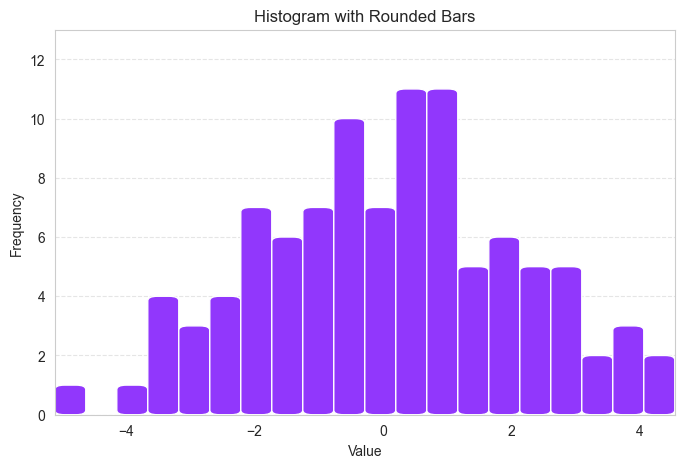

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch

# 정규분포 데이터 생성
np.random.seed(0)
data = np.random.normal(0, 2, 100)

print(data)
# 히스토그램 데이터 계산
counts, bins = np.histogram(data, bins=20)

# 히스토그램 플롯 설정
plt.figure(figsize=(8, 5))
ax = plt.gca()

# 각 막대를 둥근 모서리로 그리기
for i in range(len(bins) - 1):
    if counts[i] != 0:
        x = bins[i]

        width = bins[i + 1] - bins[i]
        
        height = counts[i]

        rect = FancyBboxPatch((x, 0), width, height,
                            boxstyle="round,pad=0,rounding_size=0.15",
                            edgecolor="white", facecolor="#9137fc")
        ax.add_patch(rect)

# 축 범위 설정
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0, max(counts) + 2)

# 격자 제거 (이 부분이 삭제됨)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False, axis='x')
# 축 및 제목 설정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Rounded Bars')
plt.show()


In [ ]:
# 25% 나눠서 얼마나 집중을 잘했는지 못했는지
# 눈 감을때 처리